### Table of Contents

* [Housing data](#Housingdata)
* [Data Analysis](#analysis)
* [Train-Test Split](#train_test_split)
* [Feature Analysis and Extraction](#features_analysis)
* [Missing Values](#missing_values)
* [Categorical Features](#categorical_features)
* [Feature Engineering](#feature_engineering)
* [Train Models](#train_models)
* [Cross Validation](#cross_validation)
* [Hyper Prameter Optimization](#hyperparam_optimization)
* [Final Model](#final_model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make this notebook's output identical at every run
np.random.seed(42)

## Housing data <a class="anchor" id="Housingdata"></a>

In [2]:
import os
import tarfile
import urllib.request
import pandas as pd


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()

In [3]:
# # same dataset fewer, slightly different features, different naming 
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing(as_frame=True)['frame']


## Data Analysis <a class="anchor" id="analysis"></a>

In [4]:

# shuffle the dataset
from sklearn.utils import shuffle
housing = shuffle(housing)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 20046 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [6]:
# numbber of distinct values per field
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# statistics of the fields 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


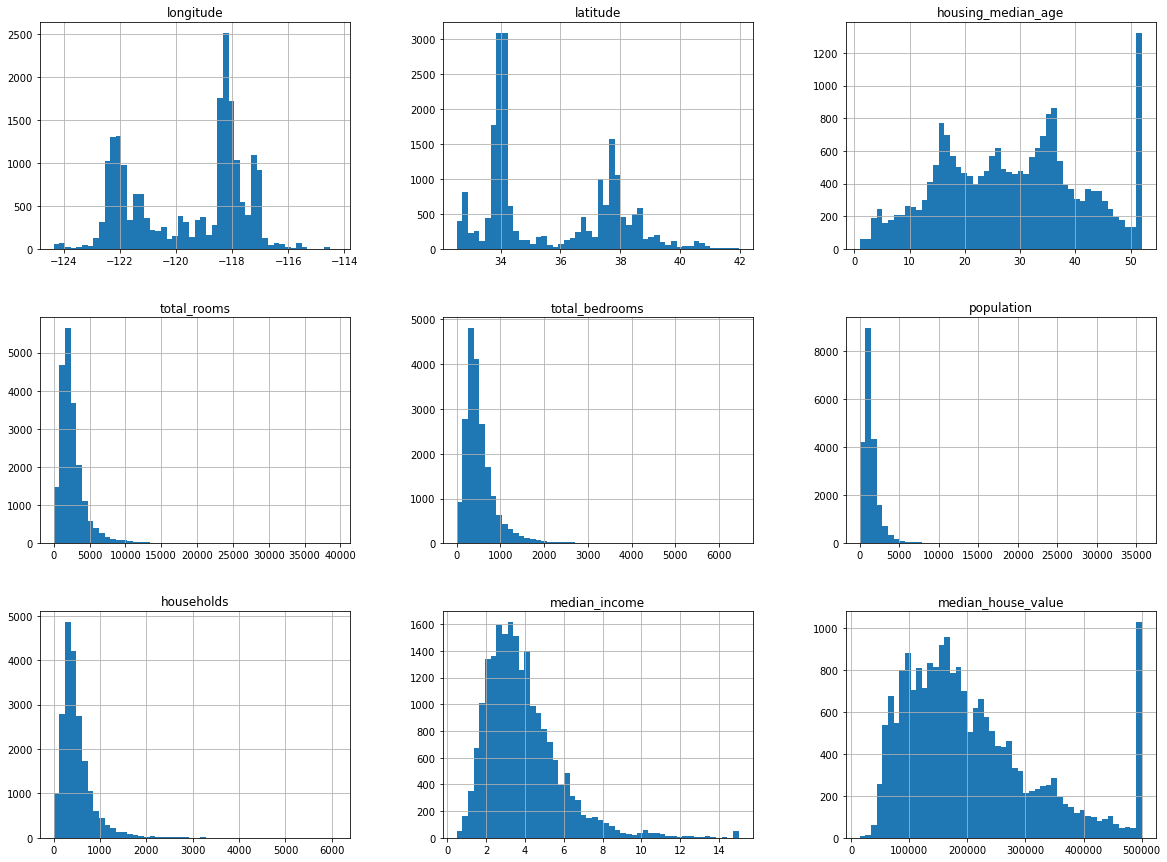

In [8]:
# plot histograms
import matplotlib.pyplot as plt
_ = housing.hist(bins=50, figsize=(20,15))


## train-test split and stratified split <a class="anchor" id="train_test_split"></a>

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(f'''
Train set size: {train_set.size}
Test set size: {test_set.size}
''')

In [ ]:
# Descretisizing the response (label)

fig, axes = plt.subplots(1,2, figsize=(16,8))
housing["median_income"].hist(ax=axes[0])
# Bin values into discrete intervals.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist(ax=axes[1])



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# here we see the difference between a stratidfied split and 
# a random one. we see that the proportions of the labels are better preserved

# StratifiedShuffleSplit
# =======================
# This cross-validation object is a merge of StratifiedKFold and
# ShuffleSplit, which returns stratified randomized folds. The folds
# are made by preserving the percentage of samples for each class.

# split.split Generate indices to split data into training and test set.
# note that each split will maintain the proportions of the classes in train and test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# just one loop here
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# verifying the stratification
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

In [ ]:
# Remove previously generated binned label
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


## Features Analysis and Extraction <a class="anchor" id="features_analysis"></a>

### Locations

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

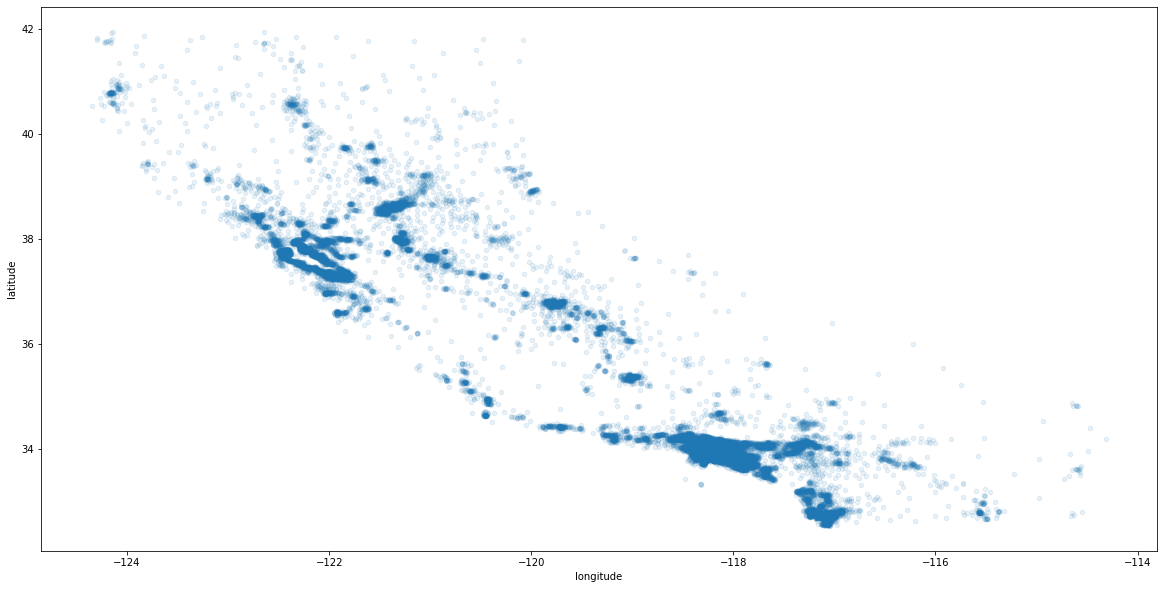

In [9]:
# view the locations 
# we use alpha=0.1 to visualize thhe density better
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


### Locations with population and median house value

In [ ]:
# another more comprehensive visualization 
# "s" = the size ot each location is set by the size if the population
# "c" = the color indicates the median_house_value 
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()


### Correlations

In [ ]:
## correlation matrix 
# min_periods: minimum number of observations required per pair of columns
# to have a valid result
corr_matrix = housing.corr(method='pearson', min_periods=1)


In [ ]:
# in the last column we see the correlation between the different features and the median 
# house value. we see that it is highly correlated with median income. Note that the values 
# indicate linear relationship, when values are low it doesn't say that the fields are independet 

corr_matrix.sort_values(by='median_house_value', key=lambda x: abs(x), ascending=False)

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

# a scatter visualizing densities of the pairs of selected variables
# among the ones specified. Note that on the diagonal we see histograms of the 
# values of the variables since if we would have plot a scatter, the plot was 
# the histogram drown on the diagonal, so no need for 3d representation

# we see that median income is highly correlated with median housing value

_ = scatter_matrix(housing[attributes], figsize=(12, 8))


### correlations with labels (response variable)

In [ ]:
# the total_rooms, total_bedrooms are dependent on the households, total_rooms 
# we will try to define better features

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# we see that bedrooms_per_room is a great new feature (the minus sign tells us 
# the hier the ratio of bedrooms the lower the median house value 
# rooms_per_household looks nice 
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(key=lambda x: abs(x), ascending=False)


In [ ]:
# split labels from features
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

## Missing values <a class="anchor" id="missing_values"></a>

In [ ]:
incomplete_rows = housing[housing.isnull().any(axis=1)]
print(f'Number of incomplete rows: {incomplete_rows.size}')
incomplete_rows.isnull().sum(axis=0).reset_index().rename(columns={'index': 'field', 0: 'missing'})

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
# option 1: drop the rows 
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    


In [ ]:

# option 2: remove the feature 
sample_incomplete_rows.drop("total_bedrooms", axis=1)    


In [ ]:
# option 3: impute - should be very carefull with imputing data this way - it changes the 
# distribbution of values. this won't effect the model only under very specific circumstances 
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
sample_incomplete_rows

### Imputation

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
housing_numerical_features = housing.select_dtypes(include=[np.number])
imputer.fit(housing_numerical_features)

print(f'The median per field for imputation {imputer.statistics_}')

# create a dataframe with the imputation - we want to retain the index 
# so we can access specific rows 
housing_tr = pd.DataFrame(imputer.transform(housing_numerical_features), 
                          columns=housing_numerical_features.columns,
                          index=housing.index)

housing_tr.loc[sample_incomplete_rows.index.values]


## Encoding categorical features <a class="anchor" id="categorical_features"></a>

In [ ]:
# Now we encode the categorical feature as numbers

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing[["ocean_proximity"]])
print(f'categories: {ordinal_encoder.categories_}')
pd.DataFrame(housing_cat_encoded[:10], housing[["ocean_proximity"]][:10])


In [ ]:
# onehot encoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])
housing_cat_1hot

## Feature engineering <a class="anchor" id="feature_engineering"></a>

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

######################################
# define a new feature using sklearn #
######################################
class CombinedAttributesAdder(TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        # nothing to learn befor transforming
        return self  
    
    def transform(self, X):
        rooms_per_household = np.expand_dims(X[:, rooms_ix] / X[:, households_ix], axis=1)
        population_per_household = np.expand_dims(X[:, population_ix] / X[:, households_ix], axis=1)
        res = [X, rooms_per_household, population_per_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = np.expand_dims(X[:, bedrooms_ix] / X[:, rooms_ix],1)
            res.append(bedrooms_per_room)
            
        return np.concatenate(res,axis=1)

#################################
# see that it works as expected #
#################################

# attr_extractor = CombinedAttributesAdder(add_bedrooms_per_room=False)

# housing_extra_attribs = pd.DataFrame(
#     attr_extractor.transform(housing.values),
#     columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
#     index=housing.index)
# housing_extra_attribs.head()

### Pipeline the transformations

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numericals_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # impute missing values
        ('attribs_adder', CombinedAttributesAdder()), # add new features
        ('std_scaler', StandardScaler()), # scale the features
    ])

housing_num_tr = numericals_pipeline.fit_transform(housing_numerical_features)

### Combine all features together

In [ ]:
from sklearn.compose import ColumnTransformer

numeric_attribs = list(housing_numerical_features)
cat_attribs = ["ocean_proximity"]

# ColumnTransformer: Applies transformers to columns of an array or pandas DataFrame.
# This is useful for heterogeneous or columnar data, to combine several feature extraction 
# mechanisms or transformations into a single transformer.
full_pipeline = ColumnTransformer([
        # List of (name, transformer, columns) tuples specifying the
        # transformer objects to be applied to subsets of the data.

        ("numericals_pipeline", numericals_pipeline, numeric_attribs),
        ("categorical_pipeline", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

num_samples, num_features = housing_prepared.shape
print(f'''
numbber of samples {num_samples}
number of features {num_features}
''')

## Train models <a class="anchor" id="train_models"></a>

here we try out 3 different estimators (models) and calculate the train error for each 

In [ ]:
from sklearn.metrics import mean_squared_error


#######################
#  Linear regression  #    
#######################
from sklearn.linear_model import LinearRegression
# Define
lin_reg = LinearRegression()
# train 
lin_reg.fit(housing_prepared, housing_labels)
# predict on training data 
housing_predictions = lin_reg.predict(housing_prepared)
# RMSE metric
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print(f'Linear Regression train error {lin_rmse}')

#######################
#    Decision tree    #
#######################
from sklearn.tree import DecisionTreeRegressor

# Define
tree_reg = DecisionTreeRegressor(random_state=42)
# train
tree_reg.fit(housing_prepared, housing_labels)
# predict on training data 
housing_predictions = tree_reg.predict(housing_prepared)
# RMSE metric
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print(f'Regression Tree train error {tree_rmse}')

###################
#  Random Forest  #
###################
from sklearn.ensemble import RandomForestRegressor
# Define
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# train
forest_reg.fit(housing_prepared, housing_labels)
# predict on training data 
housing_predictions = forest_reg.predict(housing_prepared)
# RMSE metric
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print(f'Random Forest train error {forest_rmse}')

## Cross-Validation  <a class="anchor" id="cross_validation"></a>

In [ ]:

from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

for estimator in [lin_reg, tree_reg, forest_reg]:
    # returns an array of scores of the estimator for each run of the cross validation.
    scores = cross_val_score(estimator=estimator, X=housing_prepared, y=housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
    model_type = estimator.__class__.__name__
    rmse_scores = np.sqrt(-scores)
    print(f'model type: {model_type}')
    print('=========================')
    display_scores(rmse_scores)
    print('-------------------------')
    



In [ ]:
# random forest seems the most promising 

## Hyper Parameter Optimization <a class="anchor" id="hyperparam_optimization"></a>

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
# return train score
# Computing training scores is used to get insights on how different
# parameter settings impact the overfitting/underfitting trade-off.
# However computing the scores on the training set can be computationally
# expensive and is not strictly required to select the parameters that
# yield the best generalization performance.

grid_search = GridSearchCV(
    estimator=forest_reg, 
    param_grid=param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

In [ ]:
print(f'''
best params: {grid_search.best_params_}
best estimator: {grid_search.best_estimator_}
''')


In [ ]:
# we expect to see 18 rows - one for each HP combination
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results['rmse_score'] = np.sqrt(-grid_results.mean_test_score)
grid_results.sort_values(by='rmse_score', ascending=True)[:10]

### Random Search

In [ ]:
# Random hyper parameters search 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200), # defines a uniform discrete random variable to sample from 
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    estimator=forest_reg, 
    param_distributions=param_distribs,             # the parameter space to sample from (either rv or a list to sample from)
    n_iter=10,                                      # Number of parameter settings that are sampled
    cv=5,                                           # to specify the number of folds in a `(Stratified)KFold`
    scoring='neg_mean_squared_error',               # the scoring function
    random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
# sampling two values from the discrete RV
param_distribs['n_estimators'].rvs(2)

In [ ]:
rnd_results = pd.DataFrame(rnd_search.cv_results_)[['mean_test_score', 'params']]
rnd_results['rmse_score'] = np.sqrt(-rnd_results.mean_test_score)
rnd_results.sort_values(by='rmse_score', ascending=True)

In [ ]:
# get the best estimator 
rnd_search.best_estimator_

## Final model pipeline <a class="anchor" id="final_model"></a>

In [ ]:

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# using the feature extraction and the model explicitely 
# X_test_prepared = full_pipeline.transform(X_test)
# final_predictions = final_model.predict(X_test_prepared)

# setting them in a pipeline
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("rf_model", final_model)
])
final_predictions = full_pipeline_with_predictor.predict(X_test)


final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f''' final RMSE {final_rmse} ''')


In [ ]:
# save the model

import joblib
joblib.dump(value=full_pipeline_with_predictor, filename="my_model.pkl") 
my_model_loaded = joblib.load("my_model.pkl") 


In [ ]:
# full_pipeline_with_predictor['preparation'].named_transformers_
full_pipeline_with_predictor

### Features importance for Random forest 

In [ ]:
# get categorical features (each category is a feature)
cat_encoder = full_pipeline_with_predictor['preparation'].named_transformers_['categorical_pipeline']
cat_one_hot_attribs = list(cat_encoder.categories_[0]) # ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]

# add to numeric and extra features
attributes = numeric_attribs + extra_attribs + cat_one_hot_attribs

rf_model = full_pipeline_with_predictor['rf_model']
pd.DataFrame(zip(attributes, rf_model.feature_importances_), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)


In [ ]:
## Confidence interval for the RMSE score

In [ ]:
from scipy import stats

confidence = 0.95
# take the square errors 
squared_errors = (final_predictions - y_test) ** 2
# the average is t-distributed (unknown variance)
np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1, # degrees of freedom
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
# or just assume normality :) which is ok for high enough dof

zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)


## pandas profiler <a class="anchor" id="pandas_profiler"></a>

In [ ]:
# the installation take few minutes - 
# it is recommended running it on a clean notebook with only pandas imported and the dataset read.
# when using matplotlib inline there could be some problems and errors

# pip install -U pandas-profiling[notebook]
# jupyter nbextension enable --py widgetsnbextension

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df=housing, title="Housing Data Report", explorative=True)

In [ ]:
profile